In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import segyio # to read seismic
from pathlib import Path
import random
import tensorflow as tf
import cv2

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose   
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, History
from keras import backend as K
from sklearn.model_selection import train_test_split

#colourmap
from seiscm import seismic

# what is the current directory?
current_dir = os.getcwd()
current_dir

'C:\\Users\\jkuhn\\Documents\\organized\\geohackathon\\2023'

# importing input training dataset without AGC

In [2]:
pathlist = Path(current_dir).glob('**/*_full.sgy')
all_dataset_seismic = []
for path in pathlist:   # iterating through the list of seismic data
    # because path is object not string
    path_in_str = str(path)
    #print(path_in_str)
    with segyio.open(path_in_str, 'r', ignore_geometry = True) as segyfile:
        data = segyfile.trace.raw[:]
        all_dataset_seismic.append(data)

In [3]:
seismic_dataset = [all_dataset_seismic[i] for i in [0,1,3,4,5,6,7]]  ## for training dataset
unseen_seismic_dataset = all_dataset_seismic[2]  # keeping unseen dataset with unknown ground truth

# Aligning seismic dataset to inversion dataset

In [4]:
# clipping the seismic training dataset based on the extents from the inversion
# ranges are based on the pdf document provided and the ranges as displayed in OpendTect divided by two for TWT
seismic_dataset[0] = seismic_dataset[0].T[300:1101,15450:20166]
seismic_dataset[1] = seismic_dataset[1].T[500:1101,10475:18801]
seismic_dataset[2] = seismic_dataset[2].T[500:1101,10470:18251]
seismic_dataset[3] = seismic_dataset[3].T[500:1101,7000:13951]
seismic_dataset[4] = seismic_dataset[4].T[500:1101,8475:10951]
seismic_dataset[5] = seismic_dataset[5].T[500:1101,2800:6801]
seismic_dataset[6] = seismic_dataset[6].T[500:1101,4400:7276]

In [5]:
for dataset in seismic_dataset:
    print(np.shape(dataset))

(801, 4716)
(601, 8326)
(601, 7781)
(601, 6951)
(601, 2476)
(601, 4001)
(601, 2876)


# Importing Acoustic Inversion dataset

In [6]:
def parse_trace_headers(segyfile, n_traces): # https://www.kaggle.com/code/alaahassan/seg-y-headers-and-seismic-inversion
    '''
    Parse the segy file trace headers into a pandas dataframe.
    Column names are defined from segyio internal tracefield
    One row per trace
    '''
    # Get all header keys
    headers = segyio.tracefield.keys
    # Initialize dataframe with trace id as index and headers as columns
    df = pd.DataFrame(index=range(1, n_traces + 1),
                      columns=headers.keys())
    # Fill dataframe with all header values
    for k, v in headers.items():
        df[k] = segyfile.attributes(v)[:]
    return df

In [7]:
from segysak.segy import segy_header_scan

pathlist = Path(current_dir).glob('**/*_AcousticImpedance.sgy')
acoustic_impedance_dataset = []
# coordinates = {'line':[], 'X_coord':[], 'Y_coord':[]}
for path in pathlist:   # iterating through the list of seismic data
    # because path is object not string
    path_in_str = str(path)
    #print(path_in_str)
    with segyio.open(path_in_str, 'r') as segyfile:
        data = segyfile.trace.raw[:]
#         bin_headers = segyfile.bin
#         n_traces = segyfile.tracecount
#         trace_headers = parse_trace_headers(segyfile, n_traces)
#         coordinates['X_coord'].append(trace_headers['GroupX'])
# #         coordinates['Y_coord'].append(trace_headers['GroupY'])
#         coordinates['line'].append(path_in_str)
        acoustic_impedance_dataset.append(data)

# clipping the seismic training dataset based on the extents from the inversion
# ranges are based on the pdf document provided and the ranges as displayed in OpendTect divided by two for TWT
acoustic_impedance_dataset[0] = acoustic_impedance_dataset[0].T
acoustic_impedance_dataset[1] = acoustic_impedance_dataset[1].T
acoustic_impedance_dataset[2] = acoustic_impedance_dataset[2].T
acoustic_impedance_dataset[3] = acoustic_impedance_dataset[3].T
acoustic_impedance_dataset[4] = acoustic_impedance_dataset[4].T
acoustic_impedance_dataset[5] = acoustic_impedance_dataset[5].T
acoustic_impedance_dataset[6] = acoustic_impedance_dataset[6].T

In [8]:
# coordinates = pd.DataFrame(coordinates)
# coordinates = coordinates.explode(['X_coord', 'Y_coord'])
# coordinates.head(2)

In [9]:
for dataset in acoustic_impedance_dataset:
    print(np.shape(dataset))

(801, 4716)
(601, 8326)
(601, 7781)
(601, 6951)
(601, 2476)
(601, 4001)
(601, 2876)


# Importing Bulk Modulus

In [10]:
pathlist = Path(current_dir).glob('**/*_BulkModulus.sgy')
bulk_modulus_dataset = []
for path in pathlist:   # iterating through the list of seismic data
    # because path is object not string
    path_in_str = str(path)
    with segyio.open(path_in_str, 'r') as segyfile:
        data = segyfile.trace.raw[:]
        bulk_modulus_dataset.append(data)

# clipping the seismic training dataset based on the extents from the inversion
# ranges are based on the pdf document provided and the ranges as displayed in OpendTect divided by two for TWT
bulk_modulus_dataset[0] = bulk_modulus_dataset[0].T
bulk_modulus_dataset[1] = bulk_modulus_dataset[1].T
bulk_modulus_dataset[2] = bulk_modulus_dataset[2].T
bulk_modulus_dataset[3] = bulk_modulus_dataset[3].T
bulk_modulus_dataset[4] = bulk_modulus_dataset[4].T
bulk_modulus_dataset[5] = bulk_modulus_dataset[5].T
bulk_modulus_dataset[6] = bulk_modulus_dataset[6].T

# Importing Density

In [11]:
pathlist = Path(current_dir).glob('**/*_Density.sgy')
density_dataset = []
for path in pathlist:   # iterating through the list of seismic data
    # because path is object not string
    path_in_str = str(path)
    with segyio.open(path_in_str, 'r') as segyfile:
        data = segyfile.trace.raw[:]
        density_dataset.append(data)

# clipping the seismic training dataset based on the extents from the inversion
# ranges are based on the pdf document provided and the ranges as displayed in OpendTect divided by two for TWT
density_dataset[0] = density_dataset[0].T
density_dataset[1] = density_dataset[1].T
density_dataset[2] = density_dataset[2].T
density_dataset[3] = density_dataset[3].T
density_dataset[4] = density_dataset[4].T
density_dataset[5] = density_dataset[5].T
density_dataset[6] = density_dataset[6].T

# Importing Facies

In [12]:
pathlist = Path(current_dir).glob('**/*_Facies.sgy')
facies_dataset = []
for path in pathlist:   # iterating through the list of seismic data
    # because path is object not string
    path_in_str = str(path)
    with segyio.open(path_in_str, 'r') as segyfile:
        data = segyfile.trace.raw[:]
        facies_dataset.append(data)

# clipping the seismic training dataset based on the extents from the inversion
# ranges are based on the pdf document provided and the ranges as displayed in OpendTect divided by two for TWT
facies_dataset[0] = facies_dataset[0].T
facies_dataset[1] = facies_dataset[1].T
facies_dataset[2] = facies_dataset[2].T
facies_dataset[3] = facies_dataset[3].T
facies_dataset[4] = facies_dataset[4].T
facies_dataset[5] = facies_dataset[5].T
facies_dataset[6] = facies_dataset[6].T

# Importing Permeability

In [13]:
pathlist = Path(current_dir).glob('**/*_Permeability.sgy')
permeability_dataset = []
for path in pathlist:   # iterating through the list of seismic data
    # because path is object not string
    path_in_str = str(path)
    with segyio.open(path_in_str, 'r') as segyfile:
        data = segyfile.trace.raw[:]
        permeability_dataset.append(data)

# clipping the seismic training dataset based on the extents from the inversion
# ranges are based on the pdf document provided and the ranges as displayed in OpendTect divided by two for TWT
permeability_dataset[0] = permeability_dataset[0].T
permeability_dataset[1] = permeability_dataset[1].T
permeability_dataset[2] = permeability_dataset[2].T
permeability_dataset[3] = permeability_dataset[3].T
permeability_dataset[4] = permeability_dataset[4].T
permeability_dataset[5] = permeability_dataset[5].T
permeability_dataset[6] = permeability_dataset[6].T

# Importing Poisson Ratio

In [14]:
pathlist = Path(current_dir).glob('**/*_PoissonsRatio.sgy')
poissonratio_dataset = []
for path in pathlist:   # iterating through the list of seismic data
    # because path is object not string
    path_in_str = str(path)
    with segyio.open(path_in_str, 'r') as segyfile:
        data = segyfile.trace.raw[:]
        poissonratio_dataset.append(data)

# clipping the seismic training dataset based on the extents from the inversion
# ranges are based on the pdf document provided and the ranges as displayed in OpendTect divided by two for TWT
poissonratio_dataset[0] = poissonratio_dataset[0].T
poissonratio_dataset[1] = poissonratio_dataset[1].T
poissonratio_dataset[2] = poissonratio_dataset[2].T
poissonratio_dataset[3] = poissonratio_dataset[3].T
poissonratio_dataset[4] = poissonratio_dataset[4].T
poissonratio_dataset[5] = poissonratio_dataset[5].T
poissonratio_dataset[6] = poissonratio_dataset[6].T

# Importing Porosity

In [15]:
pathlist = Path(current_dir).glob('**/*_Porosity.sgy')
porosity_dataset = []
for path in pathlist:   # iterating through the list of seismic data
    # because path is object not string
    path_in_str = str(path)
    with segyio.open(path_in_str, 'r') as segyfile:
        data = segyfile.trace.raw[:]
        porosity_dataset.append(data)

# clipping the seismic training dataset based on the extents from the inversion
# ranges are based on the pdf document provided and the ranges as displayed in OpendTect divided by two for TWT
porosity_dataset[0] = porosity_dataset[0].T
porosity_dataset[1] = porosity_dataset[1].T
porosity_dataset[2] = porosity_dataset[2].T
porosity_dataset[3] = porosity_dataset[3].T
porosity_dataset[4] = porosity_dataset[4].T
porosity_dataset[5] = porosity_dataset[5].T
porosity_dataset[6] = porosity_dataset[6].T

# Importing Shear Impedance

In [16]:
pathlist = Path(current_dir).glob('**/*_ShearImpedance.sgy')
shear_impedance_dataset = []
for path in pathlist:   # iterating through the list of seismic data
    # because path is object not string
    path_in_str = str(path)
    with segyio.open(path_in_str, 'r') as segyfile:
        data = segyfile.trace.raw[:]
        shear_impedance_dataset.append(data)

# clipping the seismic training dataset based on the extents from the inversion
# ranges are based on the pdf document provided and the ranges as displayed in OpendTect divided by two for TWT
shear_impedance_dataset[0] = shear_impedance_dataset[0].T
shear_impedance_dataset[1] = shear_impedance_dataset[1].T
shear_impedance_dataset[2] = shear_impedance_dataset[2].T
shear_impedance_dataset[3] = shear_impedance_dataset[3].T
shear_impedance_dataset[4] = shear_impedance_dataset[4].T
shear_impedance_dataset[5] = shear_impedance_dataset[5].T
shear_impedance_dataset[6] = shear_impedance_dataset[6].T

# Importing Shear Modulus

In [17]:
pathlist = Path(current_dir).glob('**/*_ShearModulus.sgy')
shear_modulus_dataset = []
for path in pathlist:   # iterating through the list of seismic data
    # because path is object not string
    path_in_str = str(path)
    with segyio.open(path_in_str, 'r') as segyfile:
        data = segyfile.trace.raw[:]
        shear_modulus_dataset.append(data)

# clipping the seismic training dataset based on the extents from the inversion
# ranges are based on the pdf document provided and the ranges as displayed in OpendTect divided by two for TWT
shear_modulus_dataset[0] = shear_modulus_dataset[0].T
shear_modulus_dataset[1] = shear_modulus_dataset[1].T
shear_modulus_dataset[2] = shear_modulus_dataset[2].T
shear_modulus_dataset[3] = shear_modulus_dataset[3].T
shear_modulus_dataset[4] = shear_modulus_dataset[4].T
shear_modulus_dataset[5] = shear_modulus_dataset[5].T
shear_modulus_dataset[6] = shear_modulus_dataset[6].T

# Importing VpVs

In [18]:
pathlist = Path(current_dir).glob('**/*_VpVs.sgy')
Vp_Vs_dataset = []
for path in pathlist:   # iterating through the list of seismic data
    # because path is object not string
    path_in_str = str(path)
    with segyio.open(path_in_str, 'r') as segyfile:
        data = segyfile.trace.raw[:]
        Vp_Vs_dataset.append(data)

# clipping the seismic training dataset based on the extents from the inversion
# ranges are based on the pdf document provided and the ranges as displayed in OpendTect divided by two for TWT
Vp_Vs_dataset[0] = Vp_Vs_dataset[0].T
Vp_Vs_dataset[1] = Vp_Vs_dataset[1].T
Vp_Vs_dataset[2] = Vp_Vs_dataset[2].T
Vp_Vs_dataset[3] = Vp_Vs_dataset[3].T
Vp_Vs_dataset[4] = Vp_Vs_dataset[4].T
Vp_Vs_dataset[5] = Vp_Vs_dataset[5].T
Vp_Vs_dataset[6] = Vp_Vs_dataset[6].T

# Importing Young Modulus

In [19]:
pathlist = Path(current_dir).glob('**/*_YoungsModulus.sgy')
YoungsModulus_dataset = []
for path in pathlist:   # iterating through the list of seismic data
    # because path is object not string
    path_in_str = str(path)
    with segyio.open(path_in_str, 'r') as segyfile:
        data = segyfile.trace.raw[:]
        YoungsModulus_dataset.append(data)

# clipping the seismic training dataset based on the extents from the inversion
# ranges are based on the pdf document provided and the ranges as displayed in OpendTect divided by two for TWT
YoungsModulus_dataset[0] = YoungsModulus_dataset[0].T
YoungsModulus_dataset[1] = YoungsModulus_dataset[1].T
YoungsModulus_dataset[2] = YoungsModulus_dataset[2].T
YoungsModulus_dataset[3] = YoungsModulus_dataset[3].T
YoungsModulus_dataset[4] = YoungsModulus_dataset[4].T
YoungsModulus_dataset[5] = YoungsModulus_dataset[5].T
YoungsModulus_dataset[6] = YoungsModulus_dataset[6].T

# Aligning ground truth to dataset

In [20]:
num = 6
print(seismic_dataset[num].shape)
print(acoustic_impedance_dataset[num].shape)

(601, 2876)
(601, 2876)


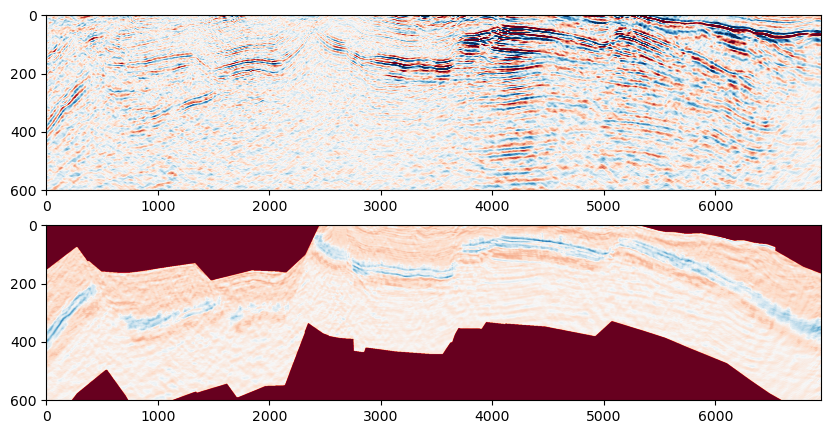

In [21]:
clip_percentile = 99
vm = np.percentile(all_dataset_seismic[0], clip_percentile)

plt.figure(figsize = (10,5))
plt.subplot(2, 1, 1)
plt.imshow(seismic_dataset[3], cmap = "RdBu", aspect = 'auto', vmin = -vm, vmax = vm)
plt.subplot(2, 1, 2)
plt.imshow(acoustic_impedance_dataset[3], cmap = "RdBu", aspect = 'auto')

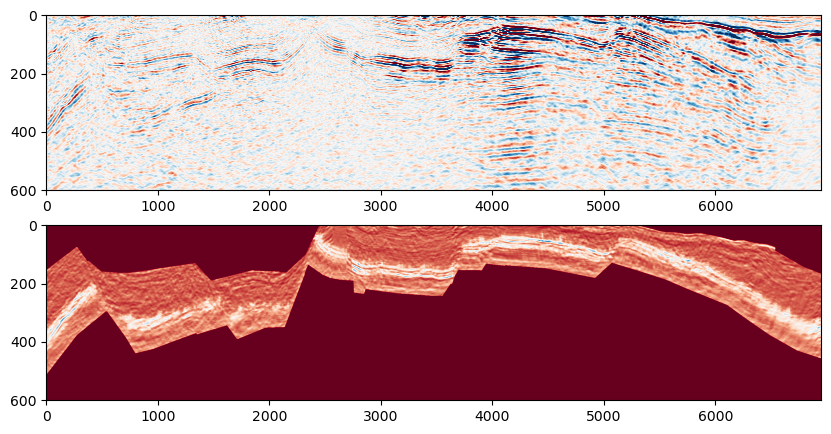

In [22]:
plt.figure(figsize = (10,5))
plt.subplot(2, 1, 1)
plt.imshow(seismic_dataset[3], cmap = "RdBu", aspect = 'auto', vmin = -vm, vmax = vm)
plt.subplot(2, 1, 2)
plt.imshow(YoungsModulus_dataset[3], cmap = "RdBu", aspect = 'auto')

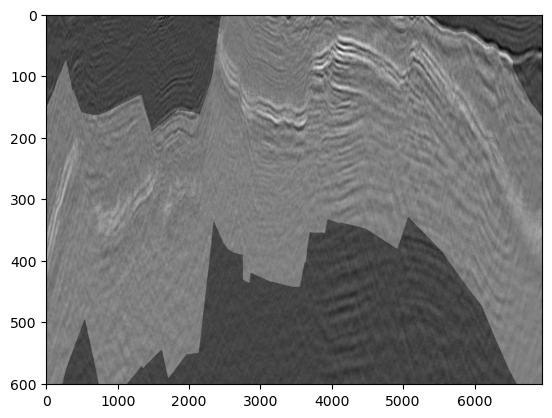

In [23]:
plt.imshow(cv2.addWeighted(seismic_dataset[3]*-1, 0.5, acoustic_impedance_dataset[3], 0.01, 0), cmap='gray', aspect = 'auto')
plt.show()

# Loading horizon data

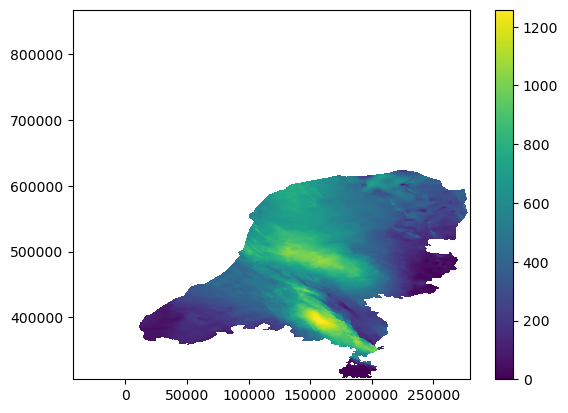

In [24]:
from zmapio import ZMAPGrid # https://github.com/abduhbm/zmapio
z_file = ZMAPGrid(current_dir + r"\Input_datasets\Horizons\1-nu_dgmdeep5_zmap\NU_dZ_onshore_DGM50_RD.zmap")
z_file.plot()
plt.colorbar()

# Resizing datasets

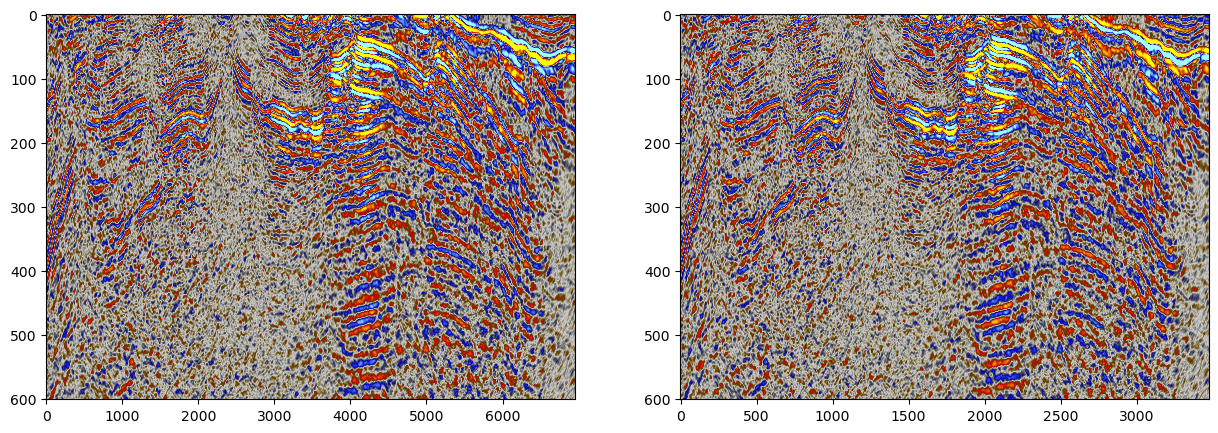

In [25]:
base_y_dims, base_x_dims = np.shape(seismic_dataset[3])
rescaled_x_dims = int(base_x_dims * 0.5)
rescaled_dataset = cv2.resize(seismic_dataset[3], dsize=(rescaled_x_dims, base_y_dims), interpolation=cv2.INTER_LINEAR)
plt.figure(figsize = (15,5))
plt.subplot(1, 2, 1)
plt.imshow(seismic_dataset[3]*-1, cmap = seismic(), aspect = 'auto', vmin = -vm, vmax = vm)
plt.subplot(1, 2, 2)
plt.imshow(rescaled_dataset, cmap = seismic(), aspect = 'auto', vmin = -vm, vmax = vm)

In [26]:
np.shape(seismic_dataset[3])

(601, 6951)

# Resizing original seismic and rock property data

In [27]:
resized_seismic_dataset = []
for a in seismic_dataset[0:4]:
    resized_seismic_dataset.append(tf.image.resize(tf.expand_dims(np.array(a),-1), (256, 256)))
resized_seismic_dataset = np.concatenate(tf.expand_dims(resized_seismic_dataset,0), axis=0)
print(resized_seismic_dataset.shape)

resized_acoustic_impedance = []
for b in acoustic_impedance_dataset[0:4]:
    resized_acoustic_impedance.append(tf.image.resize(tf.expand_dims(np.array(b),-1), (256, 256)))
resized_acoustic_impedance = np.concatenate(tf.expand_dims(resized_acoustic_impedance,0), axis=0)
print(resized_acoustic_impedance.shape)

resized_bulk_modulus = []
for b in bulk_modulus_dataset[0:4]:
    resized_bulk_modulus.append(tf.image.resize(tf.expand_dims(np.array(b),-1), (256, 256)))
resized_bulk_modulus = np.concatenate(tf.expand_dims(resized_bulk_modulus,0), axis=0)

resized_density = []
for b in density_dataset[0:4]:
    resized_density.append(tf.image.resize(tf.expand_dims(np.array(b),-1), (256, 256)))
resized_density = np.concatenate(tf.expand_dims(resized_density,0), axis=0)

resized_facies = []
for b in facies_dataset[0:4]:
    resized_facies.append(tf.image.resize(tf.expand_dims(np.array(b),-1), (256, 256)))
resized_facies = np.concatenate(tf.expand_dims(resized_facies,0), axis=0)

resized_permeability = []
for b in permeability_dataset[0:4]:
    resized_permeability.append(tf.image.resize(tf.expand_dims(np.array(b),-1), (256, 256)))
resized_permeability = np.concatenate(tf.expand_dims(resized_permeability,0), axis=0)

resized_poissonratio = []
for b in poissonratio_dataset[0:4]:
    resized_poissonratio.append(tf.image.resize(tf.expand_dims(np.array(b),-1), (256, 256)))
resized_poissonratio = np.concatenate(tf.expand_dims(resized_poissonratio,0), axis=0)

resized_porosity = []
for b in porosity_dataset[0:4]:
    resized_porosity.append(tf.image.resize(tf.expand_dims(np.array(b),-1), (256, 256)))
resized_porosity = np.concatenate(tf.expand_dims(resized_porosity,0), axis=0)

resized_shear_impedance = []
for b in shear_impedance_dataset[0:4]:
    resized_shear_impedance.append(tf.image.resize(tf.expand_dims(np.array(b),-1), (256, 256)))
resized_shear_impedance = np.concatenate(tf.expand_dims(resized_shear_impedance,0), axis=0)

resized_shear_modulus = []
for b in shear_modulus_dataset[0:4]:
    resized_shear_modulus.append(tf.image.resize(tf.expand_dims(np.array(b),-1), (256, 256)))
resized_shear_modulus = np.concatenate(tf.expand_dims(resized_shear_modulus,0), axis=0)

resized_Vp_Vs = []
for b in Vp_Vs_dataset[0:4]:
    resized_Vp_Vs.append(tf.image.resize(tf.expand_dims(np.array(b),-1), (256, 256)))
resized_Vp_Vs = np.concatenate(tf.expand_dims(resized_Vp_Vs,0), axis=0)

resized_YoungsModulus = []
for b in YoungsModulus_dataset[0:4]:
    resized_YoungsModulus.append(tf.image.resize(tf.expand_dims(np.array(b),-1), (256, 256)))
resized_YoungsModulus = np.concatenate(tf.expand_dims(resized_YoungsModulus,0), axis=0)

(4, 256, 256, 1)
(4, 256, 256, 1)


# Augmenting dataset

In [28]:
def create_augmented_data(dataset, patch_size, increment, rescale_factors=[1.0], normalise=True):
    output_list = []
    base_y_dims, base_x_dims = np.shape(dataset)
    factor = max(np.max(dataset), -np.min(dataset)) if normalise else 1.0
    for rescale_factor in rescale_factors:
        rescaled_x_dims = int(base_x_dims * rescale_factor)
        rescaled_dataset = cv2.resize(dataset, dsize=(rescaled_x_dims, base_y_dims), interpolation=cv2.INTER_LINEAR)
        for i in range (0, (rescaled_x_dims-patch_size)//increment):
            for j in range (0, (base_y_dims-patch_size)//increment):
                output_list.append(rescaled_dataset[j*increment:j*increment+patch_size, i*increment:i*increment+patch_size]/factor)
                output_list.append(np.fliplr(rescaled_dataset[j*increment:j*increment+patch_size, i*increment:i*increment+patch_size]/factor))

    return output_list

In [29]:
patch_size = 256
increment = 64
rescale_factors = [1.0]
augmented_input_data = []
augmented_imp_data = []

# do it for seismic data and petrophysical data
for input_data, imp_data in zip(seismic_dataset[0:4], 
                                acoustic_impedance_dataset[0:4]):
    augmented_input_data.extend(create_augmented_data(input_data, patch_size, increment, rescale_factors))
    augmented_imp_data.extend(create_augmented_data(imp_data, patch_size, increment, rescale_factors))

In [29]:
# augmented_bulk_mod_data = []
# augmented_density_data = []

# # do it for seismic data and petrophysical data
# for bulk_mod_data, density_data in zip(bulk_modulus_dataset[0:4], 
#                                        density_dataset[0:4]):
#     augmented_bulk_mod_data.extend(create_augmented_data(bulk_mod_data, patch_size, increment, rescale_factors))
#     augmented_density_data.extend(create_augmented_data(density_data, patch_size, increment, rescale_factors))

In [30]:
# augmented_facies_data = []
# augmented_perm_data = []

# # do it for seismic data and petrophysical data
# for facies_data, perm_data in zip(facies_dataset[0:4], 
#                                   permeability_dataset[0:4]):
#     augmented_facies_data.extend(create_augmented_data(facies_data, patch_size, increment, rescale_factors))
#     augmented_perm_data.extend(create_augmented_data(perm_data, patch_size, increment, rescale_factors))


In [31]:
# augmented_poissonratio_data = []
# augmented_poro_data = []

# # do it for seismic data and petrophysical data
# for poissonratio_data, poro_data in zip(poissonratio_dataset[0:4], 
#                                         porosity_dataset[0:4]):
#     augmented_poissonratio_data.extend(create_augmented_data(poissonratio_data, patch_size, increment, rescale_factors))
#     augmented_poro_data.extend(create_augmented_data(poro_data, patch_size, increment, rescale_factors))


In [ ]:
# augmented_shear_imp_data = []
# augmented_shear_mod_data = []

# # do it for seismic data and petrophysical data
# for shear_imp, shearmod in zip(shear_impedance_dataset[0:4], 
#                           shear_modulus_dataset[0:4]):
#     augmented_shear_imp_data.extend(create_augmented_data(shear_imp, patch_size, increment, rescale_factors))
#     augmented_shear_mod_data.extend(create_augmented_data(shearmod, patch_size, increment, rescale_factors))


In [ ]:
# augmented_VpVs_data = []
# augmented_YM_data = []

# # do it for seismic data and petrophysical data
# for VpVs_data, YM_data in zip(Vp_Vs_dataset[0:4], 
#                               YoungsModulus_dataset[0:4]):
#     augmented_VpVs_data.extend(create_augmented_data(VpVs_data, patch_size, increment, rescale_factors))
#     augmented_YM_data.extend(create_augmented_data(YM_data, patch_size, increment, rescale_factors))


In [29]:
len(augmented_input_data)

4574

In [30]:
np.shape(augmented_input_data[967])

(256, 256)

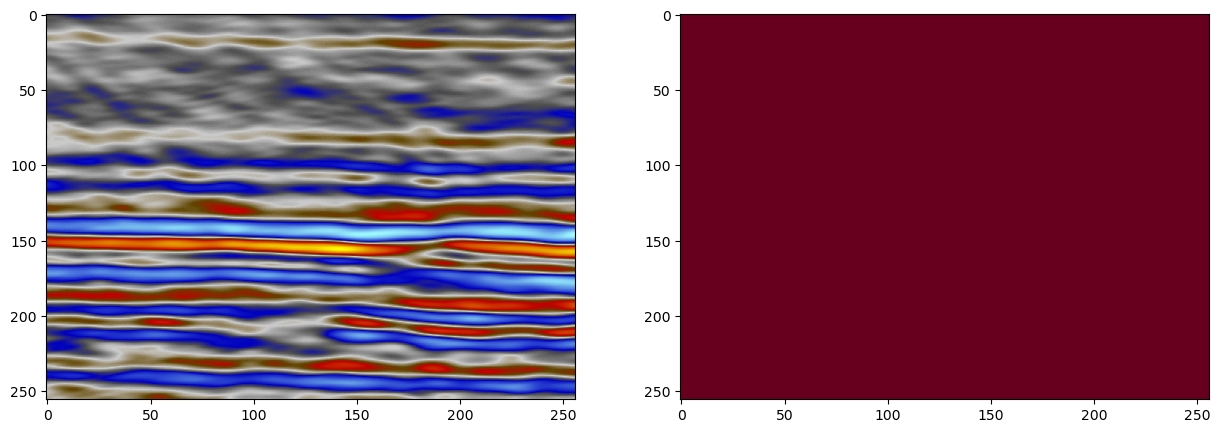

In [31]:
plt.figure(figsize = (15,5))
plt.subplot(1, 2, 1)
plt.imshow(augmented_input_data[800]*-1, cmap = seismic(), aspect = 'auto')
plt.subplot(1, 2, 2)
plt.imshow(augmented_imp_data[800], cmap = "RdBu", aspect = 'auto')

In [ ]:
# pruned_inputs = []   # pruning patches with zero
# pruned_acousticimpedance = []; pruned_bulk_mod = []; pruned_density = [];
# pruned_facies = []; pruned_perm = []; pruned_poissonratio = [];
# pruned_poro = []; pruned_shear_imp = []; pruned_shear_mod = [];
# pruned_VpVs = []; pruned_YM = [];
# prune_threshold = 0.1

# for input_data, ai_data, bulk_mod_data, density_data, facies_data, perm_data, poissonratio_data, poro_data, shear_imp, shear_mod, VpVs, YM in zip(augmented_input_data, augmented_imp_data, augmented_bulk_mod_data, augmented_density_data, augmented_facies_data, augmented_perm_data, augmented_poissonratio_data, augmented_poro_data, augmented_shear_imp_data, augmented_shear_mod_data, augmented_VpVs_data, augmented_YM_data):
#     if (np.count_nonzero(ai_data)/np.size(ai_data))>(1-prune_threshold):
#         pruned_inputs.append(input_data)
#         pruned_acousticimpedance.append(ai_data)
#         pruned_bulk_mod.append(bulk_mod_data)
#         pruned_density.append(density_data)
#         pruned_facies.append(facies_data)
#         pruned_perm.append(perm_data)
#         pruned_poissonratio.append(poissonratio_data)
#         pruned_poro.append(poro_data)
#         pruned_shear_imp.append(shear_imp)
#         pruned_shear_mod.append(shear_mod)
#         pruned_VpVs.append(VpVs)
#         pruned_YM.append(YM)

# pruned_inputs = pruned_inputs.reshape((int(pruned_inputs.shape[0]/256.0)), 256, 256)
# pruned_acousticimpedance = pruned_acousticimpedance.reshape((int(pruned_acousticimpedance.shape[0]/256.0)), 256, 256)
# pruned_bulk_mod = pruned_bulk_mod.reshape((int(pruned_bulk_mod.shape[0]/256.0)), 256, 256)
# pruned_density = pruned_density.reshape((int(pruned_density.shape[0]/256.0)), 256, 256)
# pruned_facies = pruned_facies.reshape((int(pruned_facies.shape[0]/256.0)), 256, 256)
# pruned_perm = pruned_perm.reshape((int(pruned_perm.shape[0]/256.0)), 256, 256)
# pruned_poissonratio = pruned_poissonratio.reshape((int(pruned_poissonratio.shape[0]/256.0)), 256, 256)
# pruned_poro = pruned_poro.reshape((int(pruned_poro.shape[0]/256.0)), 256, 256)
# pruned_shear_imp = pruned_shear_imp.reshape((int(pruned_shear_imp.shape[0]/256.0)), 256, 256)
# pruned_shear_mod = pruned_shear_mod.reshape((int(pruned_shear_mod.shape[0]/256.0)), 256, 256)
# pruned_VpVs = pruned_VpVs.reshape((int(pruned_VpVs.shape[0]/256.0)), 256, 256)
# pruned_YM = pruned_YM.reshape((int(pruned_YM.shape[0]/256.0)), 256, 256)


In [30]:
pruned_inputs = []   # pruning patches with zero
pruned_acousticimpedance = []; 
prune_threshold = 0.1

for input_data, ai_data in zip(augmented_input_data, 
                               augmented_imp_data):
    if (np.count_nonzero(ai_data)/np.size(ai_data))>(1-prune_threshold):
        pruned_inputs.append(input_data)
        pruned_acousticimpedance.append(ai_data)
pruned_inputs = np.concatenate(pruned_inputs)
pruned_acousticimpedance = np.concatenate(pruned_acousticimpedance, axis = 0)

pruned_inputs = pruned_inputs.reshape((int(pruned_inputs.shape[0]/256.0)), 256, 256)
pruned_inputs = tf.expand_dims(pruned_inputs, -1)
pruned_acousticimpedance = pruned_acousticimpedance.reshape((int(pruned_acousticimpedance.shape[0]/256.0)), 256, 256)
pruned_acousticimpedance = tf.expand_dims(pruned_acousticimpedance, -1)

In [31]:
len(pruned_inputs)

2230

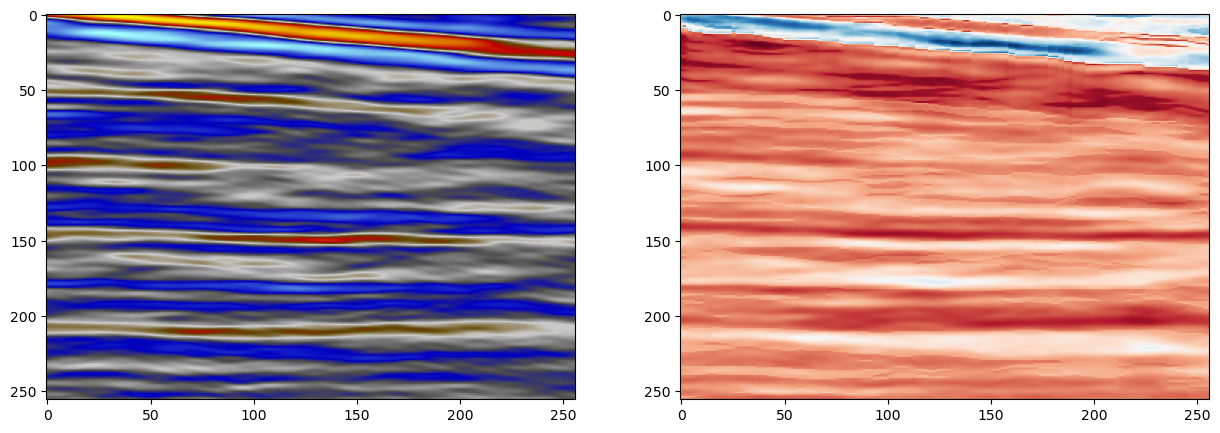

In [32]:
plt.figure(figsize = (15,5))
plt.subplot(1, 2, 1)
plt.imshow(pruned_inputs[100]*-1, cmap = seismic(), aspect = 'auto')
plt.subplot(1, 2, 2)
plt.imshow(pruned_acousticimpedance[100], cmap = "RdBu", aspect = 'auto')

# Combining patches with resized images

In [33]:
#Seismic patches with resizing
pruned_inputs = np.concatenate([pruned_inputs,resized_seismic_dataset], axis=0)
print(pruned_inputs.shape)

#combine acoustic impedance
pruned_acousticimpedance = np.concatenate([pruned_acousticimpedance, resized_acoustic_impedance], axis=0)
print(pruned_acousticimpedance.shape)

# #combine bulk modulus
# pruned_bulk_mod = np.concatenate([pruned_bulk_mod, resized_bulk_modulus], axis=0)

# #combine density dataset
# pruned_density = np.concatenate([pruned_density, resized_density], axis=0)

# #combine facies dataset
# pruned_facies = np.concatenate([pruned_facies, resized_facies], axis=0)

# #combine permeability dataset
# pruned_perm = np.concatenate([pruned_perm, resized_permeability], axis=0)

# #combine poisson ratio dataset
# pruned_poissonratio = np.concatenate([pruned_poissonratio, resized_poissonratio], axis=0)

# #combine porosity dataset
# pruned_poro = np.concatenate([pruned_poro, resized_porosity], axis=0)

# #combine shear imepdance dataset
# pruned_shear_imp = np.concatenate([pruned_shear_imp, resized_shear_impedance], axis=0)

# #combine shear modulus dataset
# pruned_shear_mod = np.concatenate([pruned_shear_mod, resized_shear_modulus], axis=0)

# #combine Vp Vs dataset
# pruned_VpVs = np.concatenate([pruned_VpVs, resized_Vp_Vs], axis=0)

# #combine Youngs Modulus dataset
# pruned_YM = np.concatenate([pruned_YM, resized_Youngs_Modulus], axis=0)

(2234, 256, 256, 1)
(2234, 256, 256, 1)


# Model building

In [34]:
def unet(input_shape, num_channels):
    inputs = Input(shape=(None, None, num_channels))

    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Center
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    # Decoder
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    # Output layer with linear activation for regression
    acousticimpedance = Conv2D(1, (1, 1), activation='linear')(conv9)
    bulkmodulus = Conv2D(1, (1,1), activation = 'linear')(conv9)
    density = Conv2D(1, (1,1), activation = 'linear')(conv9)
    facies = Conv2D(1, (1,1), activation = 'linear')(conv9)
    permeability = Conv2D(1, (1,1), activation = 'linear')(conv9)
    poissonratio = Conv2D(1, (1,1), activation = 'linear')(conv9)
    shearimpedance = Conv2D(1, (1,1), activation = 'linear')(conv9)
    shearmodulus = Conv2D(1, (1,1), activation = 'linear')(conv9)
    vpvs = Conv2D(1, (1,1), activation = 'linear')(conv9)
    youngmodulus = Conv2D(1, (1,1), activation = 'linear')(conv9)

    model = Model(inputs=[inputs], 
                  outputs= [acousticimpedance,
#                             bulkmodulus,
#                              density,
#                              facies,
#                              permeability,
#                              poissonratio,
#                              shearimpedance,
#                              shearmodulus,
#                              vpvs,
#                              youngmodulus
                            ])

    return model


input_shape = pruned_inputs[0].shape # Change this based on your image size
num_channels = 1  # Set the number of input channels (RGB images have 3 channels)

model = unet(input_shape, num_channels)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   320         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, None, None,   9248        ['conv2d[0][0]']                 
                                32)                                                           

                                                                                                  
 up_sampling2d_3 (UpSampling2D)  (None, None, None,   0          ['conv2d_15[0][0]']              
                                64)                                                               
                                                                                                  
 concatenate_3 (Concatenate)    (None, None, None,   0           ['up_sampling2d_3[0][0]',        
                                96)                               'conv2d_1[0][0]']               
                                                                                                  
 conv2d_16 (Conv2D)             (None, None, None,   27680       ['concatenate_3[0][0]']          
                                32)                                                               
                                                                                                  
 conv2d_17

In [35]:
def MSE_loss_ignore_zero(y_true, y_pred):
    isMask = K.equal(y_true, 0.0)
    #transform to float (0 or 1) and invert
    isMask = K.cast(isMask, dtype=K.floatx())
    isMask = 1 - isMask #now mask values are zero, and others are 1
    loss = np.square(np.subtract(y_true*isMask, y_pred*isMask)).mean()
    return loss

In [36]:
def custom_loss(yTrue,yPred):

    #find which values in yTrue (target) are the mask value
    isMask = K.equal(yTrue, 0.0) #true for all mask values

    #since y is shaped as (batch, length, features), we need all features to be mask values
    #isMask = K.all(isMask, axis=-1) #the entire output vector must be true
        #this second line is only necessary if the output features are more than 1

    #transform to float (0 or 1) and invert
    isMask = K.cast(isMask, dtype=K.floatx())
    isMask = 1 - isMask #now mask values are zero, and others are 1

    #multiply this by the inputs:
       #maybe you might need K.expand_dims(isMask) to add the extra dimension removed by K.all
    yTrue = yTrue * isMask   
    yPred = yPred * isMask

    return someLossFunction(yTrue,yPred)

In [37]:
model.compile(optimizer = Adam(lr = 1e-3), loss = 'MSE', metrics = 'MAE')

C:\Users\jkuhn\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [38]:
print(np.shape(pruned_inputs))
print(np.shape(pruned_acousticimpedance))

(2234, 256, 256, 1)
(2234, 256, 256, 1)


In [ ]:
history = model.fit(pruned_inputs, 
                    [pruned_acousticimpedance,
#                       pruned_bulk_mod, pruned_density, pruned_facies, 
#                       pruned_perm, pruned_poissonratio, pruned_poro,
#                      pruned_shear_imp, pruned_shear_mod,
#                       pruned_VpVs, pruned_YM
                     ], 
                    batch_size = 10, epochs = 10, 
                    verbose = 1, shuffle = True,  validation_split = 0.2)

Epoch 1/10
 93/179 [==============>...............] - ETA: 9:52 - loss: 0.0580 - MAE: 0.1512 

In [ ]:
#Saving our predictions in the directory 'preds'
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
## saving model
# model.save("model_20epochs_lr1e-4_patches_all_petro")

In [ ]:
# #loading model
# model2 = tf.keras.models.load_model('model_20epochs_lr1e-4_patches_seismic_acousticimpedance')

# Prediction

In [91]:
# scaling factor
print('seismic')
testing_seismic = seismic_dataset[5:6]
testing_seismic = tf.image.resize(tf.expand_dims(np.array(testing_seismic),-1), (256, 256))
scaled_factor = max(np.max(resized_seismic), -np.min(resized_seismic))
testing_seismic = testing_seismic/scaled_factor

print('acoustic impedance')
testing_acoustic_impedance = acoustic_impedance_dataset[5:6]
testing_acoustic_impedance = tf.image.resize(tf.expand_dims(np.array(testing_acoustic_impedance),-1), (256, 256))
scaled_factor1 = max(np.max(resized_acoustic_impedance), -np.min(resized_acoustic_impedance))
testing_acoustic_impedance = testing_acoustic_impedance/scaled_factor

print('bulk modulus')
testing_bulk_modulus = bulk_modulus_dataset[5:6]
testing_bulk_modulus = tf.image.resize(tf.expand_dims(np.array(testing_bulk_modulus),-1), (256, 256))
scaled_factor2 = max(np.max(resized_bulkmodulus_testing), -np.min(resized_bulkmodulus_testing))
testing_bulk_modulus = testing_bulk_modulus/scaled_factor

seismic


NameError: name 'resized_seismic' is not defined

In [ ]:
prediction = model.predict(testing_seismic)
prediction = tf.squeeze(prediction)
prediction.shape

In [ ]:
plt.figure(figsize = (15,10))
plt.subplot(2, 1, 1)
plt.imshow(tf.squeeze(prediction), cmap = "RdBu", aspect = 'auto')
plt.colorbar()
plt.subplot(2, 1, 2)
plt.imshow(tf.squeeze(testing_acoustic_impedance), cmap = "RdBu", aspect = 'auto')
plt.colorbar()